# Circuit Stitching

Circuit stitching is a technique used to optimize the routing of quantum circuits on physical quantum hardware. In this process, disconnected qubits, which are not physically adjacent, are brought closer together using SWAP gates. However, unlike traditional routing methods, the **qubits are not routed back** to their original positions using additional SWAP gates. This decision is made to avoid introducing unnecessary SWAP operations, which can increase the overall complexity and resource usage of the circuit.

As a result of this process, the allocation of virtual qubits, which represent the logical qubits in the circuit, may change. Virtual qubits are mapped to physical qubits on the quantum hardware, and their allocation determines the routing of the circuit. By knowing the final allocation of qubits after transpilation, we can understand how the circuit has been optimized and how the virtual qubits have been mapped to physical qubits on the quantum device. This information is essential for ensuring the efficient execution of the circuit on the target quantum hardware and for optimizing the performance of quantum algorithms.

Example of qubit allocation during transpilation:

- `Zero Map` - Ancillas added
- `After Layout` - Initial layout applied
- `After Routing` - SWAPs applied
- `Full Map` - Final qubit allocation

![image.png](Fig1_circuit_stitching.png) 
*Fig.1. Schematic illustration procedure for the circuit stitching*

## 1. Problem definition


Unfortunately, **Qiskit** does not provide such allocation. Instead - Qiskit transpiled circuit contains `layout` property with data on applied qubit permutations:

- `initial_layout` – initial placement of incoming virtual qubits during Layout stage.

- `final_layout` – placement of outgoing virtual qubits during Routing stage.

## 2. Solution: Rivet Transpilation

**The goal is** to "stitch" together transpiled circuits into a chain using `layout` property.


### 2.1. Function `transpile`

Interface of Rivet `transpile` function matches `qiskit.transpile` - but allows additional parameters like:

- pre-defined transpilation stacks
- custom PassManager
- dynamical decoupling
- transpiler options

In [1]:
from rivet_transpiler import transpile

To be able visualize the results below the `matplotlib` should be installed:

In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: qiskit-nature 0.5.2 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Backend is an simulator with properties of a real backend:

- coupling map
- basis gates
- noise model

Fake backends are useful for testing the transpiler and performing noisy simulations of the system.

For minimal example we select 5-qubit fake backend with linear topology:

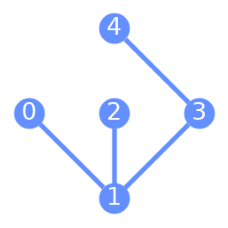

In [3]:
import qiskit
import qiskit.visualization 

from qiskit_ibm_runtime.fake_provider import FakeLimaV2

backend = FakeLimaV2() 

qiskit.visualization.plot_gate_map(backend)

![image.png](Fig2_FakeLima_backend.png) 

*Fig.2. Schematic representation of FakeLimaV2 backend.*

### 2.2. Example: transpilation for Litmus Circuit

Lets consider how the Rivet transpilation works for a simple example of litmus circuit. **Litmus circuit** is a minimal quantum circuit which consists of:

- Parametrized RZ gate on each qubit (each parameter name matches the  index of the virtual qubit - to trace consequent permutations of qubits during layout and routing phases of transpilation).

- Circular CNOT gates (necessary to introduce SWAPs during transpilation to not fully connected topology).

In [4]:
from rivet_transpiler import get_litmus_circuit

In [5]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

In [6]:
transpiled_circuit = transpile(
    litmus_circuit,
    backend,
    seed_transpiler=1234
)

transpiled_circuit.draw()

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────


### 2.3. Function `get_full_map`

Rivet function `get_full_map` follows above permutations to return final allocation of qubits after transpilation. The information about the final allocation of qubits after transpilation  ensures the effective execution of the quantum algorithms on real quantum hardware, namely taking into account the characteristics of the device architecture.

In [7]:
from rivet_transpiler import get_full_map

To find final allocation of qubits after transpilation we work with 3 sets of qubits:
- Incoming virtual qubits of the initial circuit
- Outgoing virtual qubits of the transpiled circuit
- Physical qubits of the selected backend

Final qubit allocation after transpilation:

In [8]:
get_full_map(transpiled_circuit)

[0, 2, 1, 3, 4]

### 2.4. Function `transpile_chain`

Consistently transpile and "stitch" a chain of quantum circuits.

In [9]:
from rivet_transpiler import transpile_chain

In [10]:
CHAIN = [litmus_circuit] * 5

transpiled_chain_circuit = transpile_chain(
    CHAIN,
    backend,
    seed_transpiler=1234,
    initial_layout=[0, 1, 2] 
)

transpiled_chain_circuit.draw(fold=-1)

┌──────────────┐               ┌───┐             ░    ┌──────────────┐┌───┐                            ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    ┌──────────────┐     ┌───┐          ┌───┐     ┌───┐             ░    
Litmus_0_1 -> 0 ┤ Rz(Litmus_0) ├──■─────────■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────┤ Rz(Litmus_1) ├──■──┤ X ├──■───────┤ X ├──■──┤ X ├──■──────────░────
                └──────────────┘  │         │  └─┬─┘  │          ░    └──────────────┘└─┬─┘                 │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    └──────────────┘  │  └─┬─┘  │       └─┬─┘  │  └─┬─┘  │          ░    
                ┌──────────────┐┌─┴─┐     ┌─┴─┐  │  ┌─┴─┐┌───┐ Litmus ┌──────────────┐  │  ┌───┐     ┌───┐┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    ┌──────────────┐┌─┴─┐  │  ┌─┴─┐┌───┐  │  ┌─┴─┐  │  ┌─┴─┐        ░    
Litmus_0_2 -> 1 ┤ Rz(Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├───░────┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────┤ Rz(Litmus_2) ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■─────░────
                └──────────────┘└───┘  │  └───┘     └───┘└─┬─┘   ░    └──────────────┘     └─┬─┘  │  └─┬─┘└───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    └──────────────┘└───┘     └───┘└─┬─┘     └───┘     └───┘  │     ░    
                ┌──────────────┐     ┌─┴─┐                 │     ░    ┌──────────────┐       │  ┌─┴─┐  │       ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus ┌──────────────┐                 │                      ┌─┴─┐ Litmus 
Litmus_0_0 -> 2 ┤ Rz(Litmus_2) ├─────┤ X ├─────────────────■─────░────┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────┤ Rz(Litmus_0) ├─────────────────■──────────────────────┤ X ├───░────
                └──────────────┘     └───┘                       ░    └──────────────┘          └───┘          └───┘   ░    └──────────────┘                                        └───┘   ░    └──────────────┘                                        └───┘   ░    └──────────────┘                                        └───┘   ░    
 ancilla_0 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                           
 ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Lets check topology map of the resulting circuit:

In [11]:
get_full_map(transpiled_chain_circuit)

[2, 0, 1, 3, 4]

### 2.5. Function `transpile_right'
Transpile additional circuit to the right part of existing circuit.

Lets take a transpiled circuit from the section 2.1. (transpiled litmus circuit):

In [12]:
transpiled_circuit.draw()

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

Below we create circular CNOT gates circuits (necessary to introduce SWAPs during transpilation to not fully connected topology). So we have to import Rivet functions:

In [13]:
from rivet_transpiler import get_cnot_circuit, transpile_right

In [14]:
cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT", [0, 1])
cnot_circuit.draw()

┌────────────┐      CNOT 
CNOT_0_0: ┤ Rz(CNOT_0) ├──■────░───
          ├────────────┤┌─┴─┐  ░   
CNOT_0_1: ┤ Rz(CNOT_1) ├┤ X ├──░───
          ├────────────┤└───┘  ░   
CNOT_0_2: ┤ Rz(CNOT_2) ├───────░───
          └────────────┘       ░

The implementation of `transpile_right` is time efficint and flexible for circuit stitching.

In [15]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_right_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ Litmus ┌────────────┐                     CNOT 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(CNOT_0) ├─────────────────■────░───
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    ├────────────┤┌───┐     ┌───┐┌─┴─┐  ░   
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├──░───
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    ├────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘  ░   
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(CNOT_1) ├──■──┤ X ├──■─────────░───
                └──────────────┘└───┘                            ░    └────────────┘     └───┘            ░   
 ancilla_0 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                              
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────

In [16]:
transpiled_right_circuit = transpile_right(
    central_circuit=transpiled_right_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234,
)

transpiled_right_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ Litmus ┌────────────┐                     CNOT ┌────────────┐      CNOT 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────┤ Rz(CNOT_0) ├─────────────────■────░───┤ Rz(CNOT_0) ├──■────░───
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    ├────────────┤┌───┐     ┌───┐┌─┴─┐  ░   ├────────────┤┌─┴─┐  ░   
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────┤ Rz(CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├──░───┤ Rz(CNOT_1) ├┤ X ├──░───
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    ├────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘  ░   ├────────────┤└───┘  ░   
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────┤ Rz(CNOT_1) ├──■──┤ X ├──■─────────░───┤ Rz(CNOT_2) ├───────░───
                └──────────────┘└───┘                            ░    └────────────┘     └───┘            ░   └────────────┘       ░   
 ancilla_0 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                       
 ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 2.6. Function `transpile_left`
Similarly as above the functions transpiles additional circuit to the left part of the existing circuit. We have to import Rivet function:

In [17]:
from rivet_transpiler import transpile_left

In [18]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

┌────────────────┐      ░ ┌──────────────┐          ┌───┐          ┌───┐ Litmus 
 CNOT_0_2 -> 0 ┤ Rz(1.0*CNOT_2) ├──────░─┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
               ├────────────────┤      ░ ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
 CNOT_0_0 -> 1 ┤ Rz(1.0*CNOT_0) ├──■───░─┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
               ├────────────────┤┌─┴─┐ ░ ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
 CNOT_0_1 -> 2 ┤ Rz(1.0*CNOT_1) ├┤ X ├─░─┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
               └────────────────┘└───┘ ░ └──────────────┘└───┘                            ░    
ancilla_0 -> 3 ────────────────────────────────────────────────────────────────────────────────
                                                                                               
ancilla_1 -> 4 ────────────────────────────────────────────────────────────────────────────────

In [19]:
transpiled_left_circuit = transpile_left(
    central_circuit=transpiled_left_circuit,
    left_circuit=litmus_circuit,
    backend=backend,
    seed_transpiler=1234
)

transpiled_left_circuit.draw(fold=-1)

┌──────────────────┐     ┌───┐                     ░ ┌────────────────┐      ░ ┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(1.0*Litmus_2) ├─────┤ X ├─────────────────■───░─┤ Rz(1.0*CNOT_2) ├──────░─┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────────┤┌───┐└─┬─┘┌───┐     ┌───┐┌─┴─┐ ░ ├────────────────┤      ░ ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_1 -> 1 ┤ Rz(1.0*Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─┤ Rz(1.0*CNOT_0) ├──■───░─┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────────┤└─┬─┘     └─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├────────────────┤┌─┴─┐ ░ ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_0 -> 2 ┤ Rz(1.0*Litmus_0) ├──■─────────■──┤ X ├──■────────░─┤ Rz(1.0*CNOT_1) ├┤ X ├─░─┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────────┘               └───┘           ░ └────────────────┘└───┘ ░ └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                     
 ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Conclussions

Circuit stitching implementation in Rivet transpiler gives the user tools for the effective workflows. This includes final aalocation of the qubits after transpilation, transpilation of the additional circuit to the left/right part of the existing circuit. 

The interface of Rivet `transpile*` functions matches Qiskit and allows additional parameters and flexibility.

With Rivet transpilation users are able to speed up circuits design process and calculations.